In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import statsmodels.formula.api as smf

import pylab as pl
%pylab inline

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

Populating the interactive namespace from numpy and matplotlib


### Set up the data

In [2]:
# read in cleaned data
df = gp.read_file('data/citi_docks2/citi_docks2.shp')
df = df.dropna()
df.head()

,bike,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers
0,37.500000,751.750000,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,5223,510.500000,39.500000,1561.000000,232.000000,302.0,0,0.528303,24.555556
1,0.000000,636.500000,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,14647,342.500000,112.500000,1043.000000,163.958333,488.0,9,0.217273,256.000000
2,7.666667,407.000000,3.133704,2.381631,POINT (989421.2936561276 199484.8415778317),32061.666667,8616,112.000000,166.333333,857.000000,206.666667,502.0,0,0.426971,31.166667
3,14.333333,840.666667,1.032838,1.624516,POINT (990973.8184738184 206381.12757902),62840.000000,8969,584.333333,4.000000,1745.333333,346.166667,487.0,0,0.344071,4.000000
4,12.250000,647.500000,3.216434,1.936163,POINT (983426.5668231647 204179.6463416842),75221.250000,14414,465.750000,118.500000,1062.000000,130.308333,128.0,11,0.072636,129.460417


In [18]:
# combine no vehicle units into one column
df['no_vehicle'] = df['no_vehic_1'] + df['no_vehicle']

# calculate nonlinearities
df['dist_tohom2'] = df['dist_tohom']**2
df['log_workers'] = np.log10(df['workers'])
df['log_residents'] = np.log10(df['residents'])
df['log_rides'] = np.log10(df['n_rides'])

# get rid of outlier
df = df[df['n_rides'] < 50000]
df.head()

,bike,commute_ti,dist_tohom,dist_towor,geometry,income_pc,n_rides,no_vehic_1,no_vehicle,pop,...,station_id,subway_ct,subway_dis,workers,dist_tohom2,log_workers,log_residents,log_rides,pred,resid
0,37.500000,751.750000,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,5223,510.500000,1060.500000,1561.000000,...,302.0,0,0.528303,24.555556,8.410180,1.390150,2.365488,3.717920,6089.039574,-866.039574
1,0.000000,636.500000,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,14647,342.500000,797.500000,1043.000000,...,488.0,9,0.217273,256.000000,11.161296,2.408240,2.214733,4.165749,12982.471248,1664.528752
2,7.666667,407.000000,3.133704,2.381631,POINT (989421.2936561276 199484.8415778317),32061.666667,8616,112.000000,390.333333,857.000000,...,502.0,0,0.426971,31.166667,9.820103,1.493690,2.315270,3.935306,5289.215086,3326.784914
3,14.333333,840.666667,1.032838,1.624516,POINT (990973.8184738184 206381.12757902),62840.000000,8969,584.333333,1172.666667,1745.333333,...,487.0,0,0.344071,4.000000,1.066754,0.602060,2.539285,3.952744,2007.503616,6961.496384
4,12.250000,647.500000,3.216434,1.936163,POINT (983426.5668231647 204179.6463416842),75221.250000,14414,465.750000,1050.000000,1062.000000,...,128.0,11,0.072636,129.460417,10.345446,2.112137,2.114972,4.158785,10706.367691,3707.632309


### Develop a simple model first

In [24]:
# regress number of rides on average commute distance
lm = smf.ols('n_rides ~ dist_tohom', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.089
Date:                Wed, 07 Dec 2016   Prob (F-statistic):              0.298
Time:                        18:11:24   Log-Likelihood:                -2416.3
No. Observations:                 243   AIC:                             4837.
Df Residuals:                     241   BIC:                             4844.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8947.0733   1283.226      6.972      0.000      6419.303  1.15e+04
dist_tohom   443.9672    425.378      1.044      0.298      -393.966  1281.900
==============================================================================
Omnibus:                       78.849   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.835
Skew:                           1.456   Prob(JB):                     1.65e-46
Kurtosis:                       6.513   Cond. No.                         13.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Investigation

It seems weird that there is a significant positive coefficient on distance to home. What's going on?

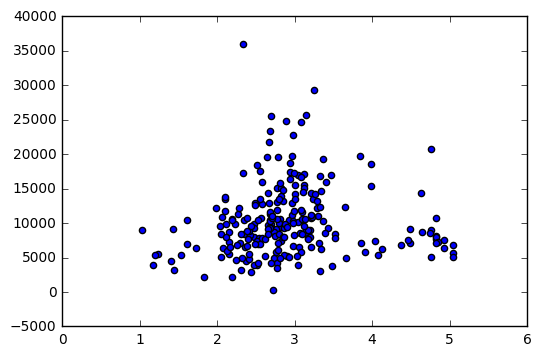

In [23]:
pl.scatter(df['dist_tohom'], df['n_rides'])

There appears to be some non linearity! Can we improve the model with polynomials?

In [8]:
lm = smf.ols('log_rides ~ dist_towor + dist_tohom2 + dist_tohom', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_rides   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     24.89
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           4.31e-14
Time:                        17:25:46   Log-Likelihood:                 54.743
No. Observations:                 249   AIC:                            -101.5
Df Residuals:                     245   BIC:                            -87.42
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       2.8139      0.164     17.196      0.000         2.492     3.136
dist_towor     -0.2467      0.036     -6.829      0.000        -0.318    -0.176
dist_tohom2    -0.0230      0.015     -1.545      0.124        -0.052     0.006
dist_tohom      0.2665      0.093      2.860      0.005         0.083     0.450
==============================================================================
Omnibus:                       12.043   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               27.306
Skew:                           0.076   Prob(JB):                     1.18e-06
Kurtosis:                       4.615   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Look at a more extensive model

In [28]:
lm = smf.ols('n_rides ~ dist_tohom + dist_tohom2 + dist_towor + \
pop + workers + residents + bike + income_pc + commute_ti + no_vehicle + subway_ct + subway_dis', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     6.925
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           1.12e-10
Time:                        18:13:43   Log-Likelihood:                -2379.4
No. Observations:                 243   AIC:                             4785.
Df Residuals:                     230   BIC:                             4830.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    3010.8376   4296.203      0.701      0.484     -5454.107  1.15e+04
dist_tohom   7628.5790   2360.454      3.232      0.001      2977.702  1.23e+04
dist_tohom2  -978.0563    398.553     -2.454      0.015     -1763.338  -192.775
dist_towor  -3507.5735   1124.282     -3.120      0.002     -5722.783 -1292.364
pop            -0.7136      1.151     -0.620      0.536        -2.982     1.555
workers         2.1096      1.139      1.852      0.065        -0.135     4.354
residents       3.8061      2.747      1.385      0.167        -1.607     9.219
bike           17.0163     20.681      0.823      0.411       -23.732    57.765
income_pc      -0.0047      0.010     -0.486      0.627        -0.024     0.014
commute_ti      2.2346      2.545      0.878      0.381        -2.779     7.248
no_vehicle     -0.5680      1.450     -0.392      0.696        -3.424     2.288
subway_ct     -18.4002     34.947     -0.527      0.599       -87.257    50.457
subway_dis  -9414.1649   3152.826     -2.986      0.003     -1.56e+04 -3202.051
==============================================================================
Omnibus:                       76.894   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.889
Skew:                           1.322   Prob(JB):                     1.22e-55
Kurtosis:                       7.240   Cond. No.                     1.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
df.corr()

,bike,commute_ti,dist_tohom,dist_towor,income_pc,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,subway_ct,subway_dis,workers,dist_tohom2,log_workers,log_residents,log_rides
bike,1.000000,0.188888,-0.098695,0.178724,-0.228035,-0.114596,0.226723,0.217738,0.268545,0.226974,-0.087861,-0.340099,0.436840,-0.299643,-0.106066,-0.364642,0.221651,-0.128234
commute_ti,0.188888,1.000000,0.492830,0.378129,0.131829,-0.012828,0.918859,0.956549,0.933154,0.239735,-0.038869,0.105669,0.049749,-0.179136,0.535578,-0.024018,0.273349,0.011850
dist_tohom,-0.098695,0.492830,1.000000,0.577496,0.392924,0.057127,0.324491,0.378632,0.423808,-0.007269,-0.054018,0.357228,-0.214378,-0.066716,0.982795,0.131228,-0.030349,0.094368
dist_towor,0.178724,0.378129,0.577496,1.000000,0.014493,-0.303863,0.277029,0.290986,0.463063,-0.026714,-0.043159,-0.065054,0.061295,-0.458100,0.632008,-0.383834,-0.049901,-0.300187
income_pc,-0.228035,0.131829,0.392924,0.014493,1.000000,0.143678,-0.077015,0.043754,-0.026516,-0.159616,-0.025805,0.365103,-0.381718,0.135898,0.353997,0.317419,-0.218214,0.158929
n_rides,-0.114596,-0.012828,0.057127,-0.303863,0.143678,1.000000,-0.022099,-0.019141,-0.106827,0.017031,-0.040695,0.254330,-0.242373,0.298800,0.008549,0.322378,0.041222,0.873282
no_vehic_1,0.226723,0.918859,0.324491,0.277029,-0.077015,-0.022099,1.000000,0.974479,0.872416,0.329522,-0.015712,-0.005693,0.171647,-0.184554,0.365285,-0.087742,0.364381,0.006929
no_vehicle,0.217738,0.956549,0.378632,0.290986,0.043754,-0.019141,0.974479,1.000000,0.900787,0.301011,-0.040896,0.034381,0.121321,-0.200286,0.414515,-0.064635,0.341130,0.012341
pop,0.268545,0.933154,0.423808,0.463063,-0.026516,-0.106827,0.872416,0.900787,1.000000,0.259861,-0.056515,-0.025010,0.194208,-0.266694,0.470091,-0.163366,0.295149,-0.100616
residents,0.226974,0.239735,-0.007269,-0.026714,-0.159616,0.017031,0.329522,0.301011,0.259861,1.000000,0.124775,-0.214595,0.342539,-0.201230,-0.023890,-0.181184,0.934765,0.057238


This overall model is not much improved but there is reason to believe some of these variables may be useful

### Feature Selection

### Another model following simple feature selection

In [34]:
lm = smf.ols('n_rides ~ dist_tohom + dist_tohom2 + dist_towor + subway_dis', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                n_rides   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     18.85
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           1.77e-13
Time:                        18:16:10   Log-Likelihood:                -2383.4
No. Observations:                 243   AIC:                             4777.
Df Residuals:                     238   BIC:                             4794.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    6000.2488   3740.149      1.604      0.110     -1367.776  1.34e+04
dist_tohom   6843.6341   2138.943      3.200      0.002      2629.956  1.11e+04
dist_tohom2  -790.8070    345.813     -2.287      0.023     -1472.052  -109.562
dist_towor  -4455.7243    872.776     -5.105      0.000     -6175.076 -2736.372
subway_dis  -7367.3481   2260.541     -3.259      0.001     -1.18e+04 -2914.124
==============================================================================
Omnibus:                       76.575   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.875
Skew:                           1.339   Prob(JB):                     1.35e-52
Kurtosis:                       7.052   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
df['pred'] = lm.predict()
df['resid'] = df['n_rides'] - df['pred']

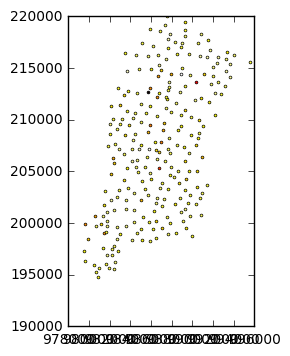

In [12]:

df.plot(column = 'resid', cmap = 'hot_r')

(array([  36.,  169.,   34.,    3.,    1.,    0.,    1.]),
 array([-11685.09485209,  -3975.80413477,   3733.48658256,  11442.77729988,
         19152.0680172 ,  26861.35873453,  34570.64945185,  42279.94016918]),
 <a list of 7 Patch objects>)

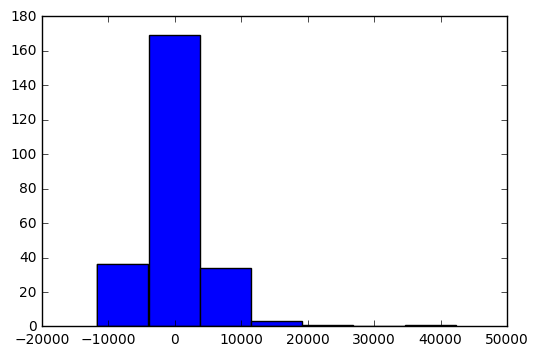

In [16]:
hist(df.resid, bins = 7)